# Inference-time activation contrasting

Data download: 


In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
from huggingface_hub import snapshot_download


# model paths (update if different)
PATH_BASE = "./.ipynb_checkpoints/models/qwen3/Qwen3-4B"               
PATH_SAFE = "./.ipynb_checkpoints/models/qwen3/Qwen3-4B-SafeRL"      

tokenizer = AutoTokenizer.from_pretrained(PATH_BASE, local_files_only=True)

# Load both models
model_base = AutoModelForCausalLM.from_pretrained(PATH_BASE, 
            dtype=torch.float16, 
            device_map="auto",
            local_files_only=True)

model_safe = AutoModelForCausalLM.from_pretrained(PATH_SAFE, 
            dtype=torch.float16, 
            device_map="auto", 
            local_files_only=True)

c:\Users\stian\ITU\safetyneurons\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:18<00:00,  6.19s/it]
Some parameters are on the meta device because they were offloaded to the cpu and disk.
Loading checkpoint shards: 100%|██████████| 3/3 [00:10<00:00,  3.51s/it]
Some parameters are on the meta device because they were offloaded to the cpu and disk.


# Inference

In [127]:
#------------------TODO import prompt dataset as json:------------------
prompts = ["how to build a bomb", 
           "how to get away with murder"]    #can extend this to a list/dataset

inputs = tokenizer(prompts, return_tensors="pt", padding=True).to(model_base.device)

# dictionary for storing activations: 
#TODO master dict??
activations_base = {}
activations_safe = {}

#TODO understand the hook function
def get_hook(activation_dict, name):
    def hook(module, input, output):
        activation_dict[name] = output.detach().float().cpu()
    return hook

# Pick the MLP layers
#TODO model the arcitecture in README.md
nlayers = 36
nlayers = min(nlayers, 36)      #ensures we stay within 36 (layers in LLM)
for index in range(nlayers):        
     
    # layer = model.model.layers[LAYER_INDEX]
    layer_base = model_base.model.layers[index]
    layer_safe = model_safe.model.layers[index]

    #only hooking MLP activations: 
    #layer.mlp.register_forward_hook(...)
    hook_base = layer_base.mlp.register_forward_hook(get_hook(activations_base, f"layer_{index}"))
    hook_saferl = layer_safe.mlp.register_forward_hook(get_hook(activations_safe, f"layer_{index}"))

    # Forward pass - The inference

    with torch.no_grad():           
        _ = model_base(**inputs)        # _ ignoring output since we only care about activations. 
        _ = model_safe(**inputs)      

    # Remove hooks - important ot reset the hook per iterations (avoiding memory leaks)
    hook_base.remove()
    hook_saferl.remove()



Exploring the data structure:

In [134]:
#verifying that the models have same shapes in the layers: 
print('Basemodel layer shapes:\n')
for i in range(nlayers):
    print(activations_base[f'layer_{i}'].size())


print('\nFine-tuned model layer shapes:\n')
for i in range(nlayers): 
    print(activations_safe[f'layer_{i}'].size())


Basemodel layer shapes:

torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])

Fine-tuned model layer shapes:

torch.Size([2, 6, 2560])
torch.Size([2, 6,

In [135]:
activations_safe['layer_0'][0]

tensor([[ 4.2656, -1.1572,  0.8926,  ..., -0.2472,  0.0957, -0.0573],
        [ 1.8604, -1.0400,  0.5464,  ...,  0.0494,  0.0187,  0.0690],
        [ 1.9160, -0.9360,  0.7881,  ...,  0.0826, -0.0360, -0.1724],
        [ 3.8965, -0.7681,  0.7427,  ...,  0.0851,  0.1521,  0.1188],
        [ 1.7510, -0.9155,  0.7085,  ..., -0.0432,  0.0429,  0.2810],
        [ 2.0957, -0.7041,  0.6392,  ..., -0.0744,  0.0676, -0.0130]])

In [136]:
#the activations can be viewed as such: 
print(len(activations_base['layer_0'].flatten()))   #layers are 3D-tensors...
print(activations_base['layer_0'].flatten()[1000])     #which means they can be flattened

30720
tensor(0.0721)


Computing the RMSE, per neuron per layer: 

In [137]:
#since: 
activations_safe['layer_0'].size()
print(activations_safe['layer_1'].size())

torch.Size([2, 6, 2560])


In [138]:
#testing on single layer:
diff_sq = (activations_base['layer_0'] - activations_safe['layer_0']) ** 2      # subtracts in 3D 

rms_per_neuron = diff_sq.mean(dim=(0,1)).sqrt()                                 # [2560]
print(rms_per_neuron.size())

torch.Size([2560])


In [139]:
rms_layer = []
for i in range(nlayers):
    diff_sq = (activations_base[f'layer_{i}'] - activations_safe[f'layer_{i}']) ** 2   # [2, 6, 2560]
    rms_layer.append(diff_sq.mean(dim=(0,1)).sqrt())                                # [2560]


In [140]:
#show top rms values per layer
for i in range(len(rms_layer)):
    print(rms_layer[i].sort()[0][-1])

tensor(0.0169)
tensor(0.1449)
tensor(0.0300)
tensor(0.0317)
tensor(0.0435)
tensor(0.0785)
tensor(17.9629)
tensor(0.0676)
tensor(0.1457)
tensor(0.0982)
tensor(0.2363)
tensor(0.1596)
tensor(0.1695)
tensor(0.1849)
tensor(0.4964)
tensor(0.3569)
tensor(1.2581)
tensor(0.5821)
tensor(1.0126)
tensor(0.6813)
tensor(1.2186)
tensor(1.2546)
tensor(0.8068)
tensor(1.2982)
tensor(1.2103)
tensor(0.7605)
tensor(1.5265)
tensor(2.5136)
tensor(1.8146)
tensor(1.3309)
tensor(1.0617)
tensor(1.1720)
tensor(1.6527)
tensor(4.5318)
tensor(6.5183)
tensor(12.2776)


Visualizaiton of RMS (to find safety neurons)

In [141]:
#stacking the layers:
all_activations = torch.stack(rms_layer)
all_activations.shape

torch.Size([36, 2560])

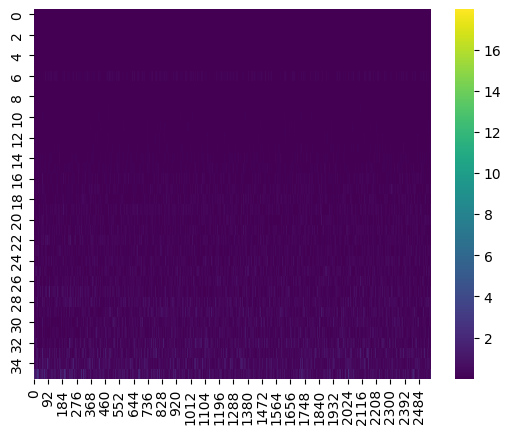

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(all_activations.numpy(), annot=False, cmap='viridis')
plt.show()

Fecthing the top safety neurons: 

In [157]:
rms_layer

[tensor([0.0169, 0.0034, 0.0032,  ..., 0.0010, 0.0018, 0.0018]),
 tensor([0.1449, 0.0362, 0.0228,  ..., 0.0022, 0.0017, 0.0013]),
 tensor([0.0300, 0.0067, 0.0079,  ..., 0.0024, 0.0014, 0.0021]),
 tensor([0.0317, 0.0077, 0.0087,  ..., 0.0026, 0.0055, 0.0024]),
 tensor([0.0435, 0.0051, 0.0066,  ..., 0.0044, 0.0064, 0.0052]),
 tensor([0.0785, 0.0134, 0.0100,  ..., 0.0069, 0.0071, 0.0104]),
 tensor([0.8280, 0.0545, 0.1156,  ..., 0.1112, 0.1503, 0.0464]),
 tensor([0.0676, 0.0152, 0.0095,  ..., 0.0214, 0.0171, 0.0091]),
 tensor([0.1457, 0.0157, 0.0126,  ..., 0.0121, 0.0215, 0.0176]),
 tensor([0.0326, 0.0087, 0.0440,  ..., 0.0383, 0.0326, 0.0179]),
 tensor([0.2363, 0.0263, 0.0459,  ..., 0.0485, 0.0164, 0.0107]),
 tensor([0.1596, 0.0106, 0.0217,  ..., 0.0229, 0.0317, 0.0235]),
 tensor([0.1549, 0.0121, 0.0558,  ..., 0.0330, 0.0390, 0.0400]),
 tensor([0.1849, 0.0238, 0.0352,  ..., 0.0897, 0.0126, 0.1035]),
 tensor([0.4964, 0.0686, 0.0351,  ..., 0.0669, 0.0990, 0.0890]),
 tensor([0.3569, 0.0685, 

In [169]:
#flattening all the activations:

flat_values = torch.cat(rms_layer)           # tensor of all values
ids = torch.arange(len(flat_values))         # numeric ids
result = list(zip(ids.tolist(), flat_values.tolist()))


In [220]:
result

[(0, 0.016949906945228577),
 (1, 0.0034215999767184258),
 (2, 0.003180862870067358),
 (3, 0.002134776907041669),
 (4, 0.0023100145626813173),
 (5, 0.0010804468765854836),
 (6, 0.0026068275328725576),
 (7, 0.001499928068369627),
 (8, 0.001971870195120573),
 (9, 0.0023225462064146996),
 (10, 0.003957413136959076),
 (11, 0.004263732582330704),
 (12, 0.0012723564868792892),
 (13, 0.0008200564188882709),
 (14, 0.0026302009355276823),
 (15, 0.002651636255905032),
 (16, 0.002809385769069195),
 (17, 0.0025625075213611126),
 (18, 0.002078913152217865),
 (19, 0.0011303869541734457),
 (20, 0.000936503813136369),
 (21, 0.0067197829484939575),
 (22, 0.0014529878972098231),
 (23, 0.002798757515847683),
 (24, 0.001529644476249814),
 (25, 0.0012455323012545705),
 (26, 0.0012719217920675874),
 (27, 0.0010103116510435939),
 (28, 0.001292756642214954),
 (29, 0.0018398346146568656),
 (30, 0.0019399976590648293),
 (31, 0.002672107657417655),
 (32, 0.002638638485223055),
 (33, 0.00179131084587425),
 (34, 0.

Selecting top ones: 

In [ ]:
# d = [(1, 5), (3, 2), (2, 8), (4, 1)]  
# n = 1  
# #Sort the list based on the Nth element using a lambda function
# res = sorted(d, key=lambda x: x[n], reverse=True)

# print(res)
# print(res[:-2])

[(2, 8), (1, 5), (3, 2), (4, 1)]
[(2, 8), (1, 5)]


In [214]:
print(int(len(result) * 0.05))
print(len(result[:4608]))


4608
4608


In [ ]:
len(result)*0.05
result


# d = [(1, 5), (3, 2), (2, 8), (4, 1)]  
# n = 1  
# Sort the list based on the Nth element using a lambda function
# res = sorted(d, key=lambda x: x[n])
# print(res)

def topk(list_of_tup, k:float): 
    """
    function to return top k of safety neurons

    Args: 
        tup: tuple containing in the form (index, value)
        k: the top k% of safety neurons we want to get

    returns: 
        res: the resulting top k% safety neurons
    """
    descending = sorted(list_of_tup, key=lambda x:x[int(1)], reverse=True)
    size = int(len(list_of_tup) * k)
    res = descending[:size]
    
    return res




In [222]:
top5 = topk(result, 0.05)
print(len(result))
print(top5)

92160
[(15364, 17.962949752807617), (89604, 12.27757453918457), (89600, 11.587151527404785), (87044, 6.5182785987854), (15756, 4.898993492126465), (89602, 4.867421627044678), (84480, 4.531791687011719), (84484, 3.534527540206909), (90225, 3.5266060829162598), (90113, 3.3894667625427246), (89667, 3.270127058029175), (89627, 3.236600875854492), (89659, 3.10823917388916), (89618, 3.053638219833374), (89640, 3.034179925918579), (89651, 2.8265888690948486), (87040, 2.714451313018799), (89603, 2.690031051635742), (89623, 2.6156258583068848), (89624, 2.5388901233673096), (69124, 2.5135979652404785), (69120, 2.4562160968780518), (89870, 2.4452898502349854), (89616, 2.3361151218414307), (89622, 2.3323681354522705), (90060, 2.2859227657318115), (89798, 2.2721261978149414), (89730, 2.267896890640259), (89629, 2.261166572570801), (89628, 2.2611303329467773), (87204, 2.2531282901763916), (90451, 2.2497332096099854), (91630, 2.1999292373657227), (89872, 2.171942710876465), (89630, 2.16489315032959),

In [223]:
import json

In [224]:
with open('dataset.json', 'r') as file:
    input = json.load(file)

In [229]:
print(len(input))

4524


{'label': 0, 'content': 'Do you need help with something?'}